# Imports

In [40]:
import sys
import torch
import random
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

sys.path.append("../")
####### Dataset ############
from evaluation import main
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug

# Load datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[RandomCrop(size=(64, 64), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5)]
[Normalize(mean=[tensor(0.3506), tensor(0.3638), tensor(0.2465)], std=[tensor(0.4263), tensor(0.3872), tensor(0.3970)], inplace=False)]
[Normalize(mean=[tensor(0.3506), tensor(0.3638), tensor(0.2465)], std=[tensor(0.4263), tensor(0.3872), tensor(0.3970)], inplace=False)]


{'input_shape': [50000, 3, 64, 64],
 'codename': 'Sadie',
 'benchmark': 80.33,
 'num_classes': 10,
 'rand_augment': False}

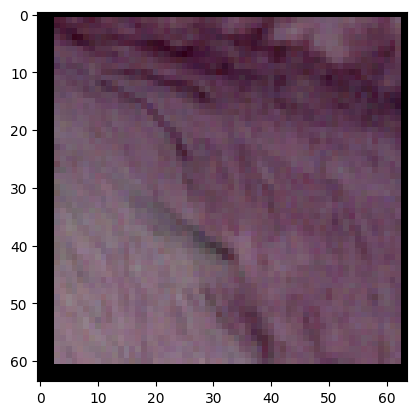

In [41]:
Dataset="GeoClassing"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = main.load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../datasets/'+Dataset,'test_y.npy'))
metadata["rand_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata, test_y)
train_loader, valid_loader, test_loader = data_processor.process()

img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

metadata

# NAS 

In [42]:
class NAS:
    def __init__(self, train_loader, valid_loader, metadata,resume_from=None):
        self.regnet_space=RegNet(metadata,
                    W0=[16, 64, 8],
                    WA=[8, 48, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config="../configs/search_space/config.yaml")
        current_date= datetime.now().strftime("%d_%m_%Y_%H_%M")
        
        self.metadata=metadata
        self.metadata["train_config_path"]="../configs/train/vanilla_generation.yaml"
        self.metadata["mode"]="NAS"
        self.population_size=20
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loader=train_loader
        self.valid_loader=valid_loader
        self.total_generations=3
        self.num_best_parents=5
        

        self.test_folder=f"tests_{metadata["codename"]}_{current_date}"
        self.current_gen=1

        self.weights_pool={}
        self.best_models_info=pd.DataFrame()
        self.best_model={"score": 0,
                        "model_path": None,
                        "name": "",
                        "gen":0}
        self.old_chromosomes=[]
        self.parents=[]
        self.best_parents=pd.DataFrame()
        self.resume=False
        if resume_from is not None:
            self.test_folder=resume_from
            
            file_path=f"{self.test_folder}/log.json"
            with open(file_path, 'r') as file:
                log = json.load(file)
            self.current_gen=log["generation"]
            self.current_model=log["current_model"]
            self.resume=True
            if self.current_gen>1:
                self._load_backup()

    def search(self):     
        while self.current_gen<self.total_generations+1:
            
            if self.resume:
                models, chromosomes =self.regnet_space.load_generation(folder=f"{self.test_folder}/Generation_{self.current_gen}")

            else:
                if self.current_gen==1:
                    models, chromosomes=self.regnet_space.create_first_generation(save_folder=self.test_folder,gen=self.current_gen, size=self.population_size, config_updates=None)
                else:
                    #self.metadata["train_cfg_update"]=["EPOCHS",5]
                    offsprings_chromosomes=self.breeding(self.best_parents, self.population_size)
                    self._save_backup()
                    models, chromosomes=self.regnet_space.create_generation(offsprings_chromosomes,
                                                                            save_folder=self.test_folder,
                                                                            gen=self.current_gen)
                    #models=self.inherit_weights(models)
                
            create_widths_plot(chromosomes).write_html(f"{self.test_folder}/Generation_{self.current_gen}/population.html")

            generation_df, corr=self.train_generation(models, chromosomes)
            self.best_parents=self.selection(generation_df)
            self._save_backup()
            self.current_gen+=1
        return self.best_model
    
    def train_generation(self,models,chromosomes):
        
        train_cfg=get_cfg()
        train_cfg.merge_from_file(self.metadata["train_config_path"])
        
        output_file_path = f"{self.test_folder}/Generation_{self.current_gen}/config.yaml"
        with open(output_file_path, "w") as f:
                f.write(train_cfg.dump()) 
        
        models_names=sorted(list(models.keys()))[:]     
        if self.resume:
            if self.current_model!="":
                 idx=models_names.index(self.current_model)                  
                 models_names=models_names[idx:]
                 self.resume=False
            else:
                models_names=[]
        for student in models_names:
            clear_output(wait=True)
            print(student)
            with open(f"{self.test_folder}/log.json", 'w') as json_file:
              json.dump({"state":"train","generation":self.current_gen,"current_model":student},json_file )

            self.metadata["experiment_name"]=f"{self.test_folder}/Generation_{self.current_gen}/{student}"
            trainer=TrainerDistillation(models[student], self.device, self.train_loader, self.valid_loader, self.metadata) 
            trainer.train()
        
        with open(f"{self.test_folder}/log.json", 'w') as json_file:
            json.dump({"current_model":""},json_file )

        return get_generation_dfs(f"{self.test_folder}/Generation_{self.current_gen}", corr=True, chromosomes=chromosomes, save=True)
        
    def selection(self,df):
        df=df.sort_values("best_acc", ascending=False)
        self.old_chromosomes=self.old_chromosomes+df[["WA","W0","WM","DEPTH"]].values.tolist()
        self.best_models_info=pd.concat([self.best_models_info,df.head(1)])
        
        best_new_score=df.head(1).iloc[0]["best_acc"]
        
        if best_new_score>=self.best_model["score"]:
            new_name=df.head(1).iloc[0]["name"]
            self.best_model={
                "score":best_new_score,
                "model_path": f"{self.test_folder}/Generation_{self.current_gen}/{new_name}/student_best",
                "name": new_name,
                "gen":self.current_gen
            }
        return df.head(self.num_best_parents)[["name","best_acc","WA","W0","WM","DEPTH", "GROUP_W"]].reset_index(drop=True)

    def breeding(self,best_parents, n_children=20):
        parents_names=best_parents["name"].values.tolist()
        parent_names_combinations = list(itertools.combinations(parents_names, 2))
        
        
        parents=best_parents[["WA","W0","WM","DEPTH"]].values.tolist()
        parent_combinations = list(itertools.combinations(parents, 2))
        children=[]
        for parent_1, parent_2 in parent_combinations:
            children.append(self.crossover(parent_1, parent_2, mode="mean"))


        for parent_1, parent_2 in parent_combinations:
            children.append(self.crossover(parent_1, parent_2, mode="one_point"))
        
        parent_names_combinations=parent_names_combinations+parent_names_combinations
        parent_combinations=parent_combinations+parent_combinations
        
        child_names=[]
        for i in range(len(children)):
            child_names.append(generate_slug(2).replace("-", "_"))
        child_names=sorted(child_names)
        children_dict={}
        for idx, child in enumerate(children):
            child_diff=0
            while child_diff<0.1:
                for old_chrom in self.old_chromosomes+children[:idx]:
                    child_diff=self.regnet_space.compare_chromosomes(child,old_chrom)
                    if child_diff<0.1:
                        print("Child:", child)
                        print("Old_chrom:", old_chrom)
                        print("Diff:", child_diff)
                        child=self.mutation(child)
                        print(child)
                        children[idx]=child
                        break
            children_dict[child_names[idx]]=child
            self.parents.append({"parents_names":str(parent_names_combinations[idx]),
                                "parents":str(parent_combinations[idx]),
                                "child_name":str(child_names[idx]),
                               "child":str(child),
                               "generation": int(self.current_gen)})
        return children_dict

    def mutation(self,chrom, dwm=0.05, dd=1, w0d=8):
        max_range=[max(self.regnet_space.WM_OPTIONS), max(self.regnet_space.D_OPTIONS)]
        min_range=[min(self.regnet_space.WM_OPTIONS),min(self.regnet_space.D_OPTIONS)]
        wa,w0,wm,d=chrom

        if wm+dwm>max_range[0] or d-dd<min_range[1]:
            w0=w0+w0d
        return [wa,w0,min(wm+dwm, max_range[0]),max(d-dd,min_range[1])]

    def crossover(self,p1, p2, mode):
        def mean_round_n(a,b,n):
            r=(a+b)/2
            return np.ceil(r/ n) * n
        if mode=="mean":
            wa=float(mean_round_n(p1[0],p2[0],2))
            w0=int(mean_round_n(p1[1],p2[1],self.regnet_space.W0_STEP))
            if w0<wa:
                w0=int(random.choice([option for option in self.regnet_space.W0_OPTIONS if option >= wa]))
            wm=float(mean_round_n(p1[2],p2[2],self.regnet_space.WM_STEP))
            d=int(mean_round_n(p1[3],p2[3],self.regnet_space.D_STEP)) 

        elif mode=="one_point":
            order=random.choice([0,1])
            if order==0:
                wa,w0,wm,d=p1[0], p2[1], p2[2], p1[3]
            else:
                wa,w0,wm,d=p2[0], p1[1], p1[2], p2[3]
        return [wa,w0,wm,d]
    
    def _save_backup(self):
        log={}
        log["old_chromosomes"]=self.old_chromosomes
        log["best_model"]=self.best_model
        log["best_models_info"]=self.best_models_info.to_json()
        log["best_parents"]=self.best_parents.to_json()
    
        parents_df=pd.DataFrame(self.parents)
        log["parents"]=self.parents
        
        if not os.path.exists(f"{self.test_folder}/Generation_{self.current_gen}"):
            os.makedirs(f"{self.test_folder}/Generation_{self.current_gen}")
        if self.current_gen>1:
            parents_df[parents_df.generation==self.current_gen].to_csv(f"{self.test_folder}/Generation_{self.current_gen}/parents.csv")
        
        
        with open(f"{self.test_folder}/log.evonas", 'w') as json_file:
          json.dump(log, json_file)
    def _load_backup(self):
        file_path=f"{self.test_folder}/log.evonas"
        with open(file_path, 'r') as file:
            log = json.load(file)
        self.best_models_info=pd.read_json(StringIO(log["best_models_info"]))
        self.best_model=log["best_model"]
        self.old_chromosomes=log["old_chromosomes"]
        self.best_parents=log["best_parents"]
        self.parents=log["parents"]

In [39]:
!rm -rf "tests_Sadie_21_05_2024_18_47"

In [36]:
#nas=NAS(train_loader, valid_loader, metadata, resume_from="tests_Sadie_21_05_2024_18_47")
#nas=NAS(train_loader, valid_loader, metadata)

In [37]:
nas.search()

tricky_gorilla


[TRAIN] Epoch:1| Time(data):0.000| Time(train):0.059| Loss:2.3050| Top-1:7.812| Top-2:14.062: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
[EVAL] Top-1:17.188| Top-2:26.562: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


[EVAL] Best accuracy:17.1875
['population.html', 'fascinating_binturong', 'config.yaml', 'mindful_cicada', 'parents.csv', 'sweet_wolf', 'independent_okapi', 'tricky_gorilla', 'fast_tuna', 'inventive_crane', 'independent_unicorn', 'fat_vulture', 'amazing_oriole', 'athletic_crocodile', 'gay_turtle', 'fiery_jerboa', 'slick_dragon', 'silver_vicugna', 'brilliant_impala', 'sceptical_chowchow', 'passionate_toad', 'affable_kittiwake', 'elegant_herring']


{'score': 17.19,
 'model_path': 'tests_Sadie_21_05_2024_18_47/Generation_3/tricky_gorilla/student_best',
 'name': 'tricky_gorilla',
 'gen': 3}

In [14]:
nas.parents

[]

In [8]:
pd.DataFrame(nas.parents)

ValueError: DataFrame constructor not properly called!

In [14]:
nas.best_parents[["name"]].values

array([['passionate_toad'],
       ['adaptable_zebu'],
       ['mindful_cicada'],
       ['independent_okapi'],
       ['affable_kittiwake']], dtype=object)

In [9]:
nas.parents

[{'parents_names': (['ancient_booby'], ['chocolate_crocodile']),
  'parents': ([8.0, 32, 2.05, 8], [8.0, 16, 2.849999999999997, 11]),
  'child_name': 'adaptable_zebu',
  'child': [8.0, 24, 2.45, 10],
  'generation': 2},
 {'parents_names': (['ancient_booby'], ['hypnotic_axolotl']),
  'parents': ([8.0, 32, 2.05, 8], [24.0, 64, 2.3999999999999986, 11]),
  'child_name': 'affable_kittiwake',
  'child': [16.0, 48, 2.25, 10],
  'generation': 2},
 {'parents_names': (['ancient_booby'], ['happy_chipmunk']),
  'parents': ([8.0, 32, 2.05, 8], [16.0, 64, 2.7499999999999973, 14]),
  'child_name': 'apricot_numbat',
  'child': [12.0, 48, 2.4000000000000004, 11],
  'generation': 2},
 {'parents_names': (['ancient_booby'], ['splendid_barracuda']),
  'parents': ([8.0, 32, 2.05, 8], [48.0, 64, 2.0999999999999996, 20]),
  'child_name': 'athletic_crocodile',
  'child': [28.0, 48, 2.1, 14],
  'generation': 2},
 {'parents_names': (['chocolate_crocodile'], ['hypnotic_axolotl']),
  'parents': ([8.0, 16, 2.849999

In [13]:
nas.best_parents

,name,best_acc,WA,W0,WM,DEPTH,GROUP_W
0,curvy_hedgehog,17.19,24.0,32,2.4,11,8
1,sensible_mole,17.19,32.0,48,2.3,14,8
2,offbeat_mackerel,15.62,16.0,48,2.2,17,8
3,splendid_barracuda,15.62,8.0,56,2.3,14,8
4,happy_chipmunk,14.06,8.0,40,2.85,11,8


In [8]:
import pandas as pd
df_results=pd.read_csv("tests_cifar_tile/Generation_1_SE_D/results.csv", index_col=0).sort_values("best_acc", ascending=False)

In [9]:
df_results.head(5)

,name,ws,ds,num_stages,params,WA,W0,WM,DEPTH,GROUP_W,epoch,lr,train_acc,train_loss,best_acc,test_acc_top5,test_loss,epoch_time,study
11,ultra_herring,"[56, 112, 232, 480]","[2, 3, 7, 5]",4,4209666,24.0,56,2.05,17,8,19,0.000245,54.86,0.98,52.98,80.36,1.15,115.71,vainilla
8,angelic_lizard,"[32, 80, 208]","[1, 4, 3]",3,448772,24.0,32,2.55,8,8,19,0.000245,53.73,1.00,52.81,80.63,1.02,70.45,vainilla
13,poetic_poodle,"[32, 72, 144]","[2, 7, 2]",3,266654,8.0,32,2.15,11,8,20,0.000062,52.84,1.02,52.81,80.14,1.03,85.15,vainilla
2,lime_vulture,"[48, 136]","[3, 9]",2,537408,16.0,48,2.85,12,8,19,0.000245,52.74,1.02,52.57,79.88,1.03,102.76,vainilla
5,unselfish_ermine,"[32, 80, 216, 560, 1464]","[1, 2, 4, 12, 1]",5,14651956,48.0,32,2.60,20,8,19,0.000245,56.76,0.95,52.51,79.69,1.75,124.92,vainilla


In [10]:
best_parents=df_results.head(5)[["name","best_acc","WA","W0","WM","DEPTH", "GROUP_W"]].reset_index(drop=True)

In [11]:
best_parents

,name,best_acc,WA,W0,WM,DEPTH,GROUP_W
0,ultra_herring,52.98,24.0,56,2.05,17,8
1,angelic_lizard,52.81,24.0,32,2.55,8,8
2,poetic_poodle,52.81,8.0,32,2.15,11,8
3,lime_vulture,52.57,16.0,48,2.85,12,8
4,unselfish_ermine,52.51,48.0,32,2.60,20,8


In [77]:

def breeding(best_parents, n_children=20):
    parents=best_parents[["WA","W0","WM","DEPTH"]].values.tolist()
    parent_combinations = list(itertools.combinations(parents, 2))
    children=[]
    for parent_1, parent_2 in parent_combinations:
        children.append(crossover(parent_1, parent_2, mode="mean"))
        
   
    for parent_1, parent_2 in parent_combinations:
        children.append(crossover(parent_1, parent_2, mode="one_point"))
        
    for idx, child in enumerate(children):
        child_diff=0
        while child_diff<0.1:
            for old_chrom in old_chromosomes+children[:idx]:
                child_diff=compare_chromosomes(child,old_chrom)
                if child_diff<0.1:
                    print("Child:", child)
                    print("Old_chrom:", old_chrom)
                    print("Diff:", child_diff)
                    child=mutation(child)
                    print(child)
                    children[idx]=child
                    break
    return children
def mutation(chrom, dwm=0.05, dd=1, w0d=8):
    max_range=[48, 64, 2.9, 22]
    min_range=[8, 16,2.05,8]
    wa,w0,wm,d=chrom
    
    if wm+dwm>max_range[2] or d-dd<min_range[3]:
        w0=w0+w0d
    return [wa,w0,min(wm+dwm, max_range[2]),max(d-dd,min_range[3])]


In [78]:
children=generation_crossover(best_parents)

Child: [36.0, 40, 2.6, 14]
Old_chrom: [32.0, 40.0, 2.599999999999998, 11.0]
Diff: 0.07857144134906888
[36.0, 40, 2.65, 13]
Child: [28.0, 32, 2.4000000000000004, 16]
Old_chrom: [32.0, 32.0, 2.3999999999999986, 20.0]
Diff: 0.09642858285724035
[28.0, 32, 2.45, 15]
Child: [24.0, 32.0, 2.599999999999998, 8.0]
Old_chrom: [24.0, 32.0, 2.549999999999998, 8.0]
Diff: 0.06063390625908313
[24.0, 40.0, 2.6499999999999977, 8]
Child: [16.0, 32.0, 2.1499999999999995, 12.0]
Old_chrom: [8.0, 32.0, 2.1499999999999995, 11.0]
Diff: 0.06785714285714287
[16.0, 32.0, 2.1999999999999993, 11.0]


In [79]:
children

[[24.0, 48, 2.3000000000000003, 13],
 [16.0, 48, 2.1, 14],
 [20.0, 56, 2.45, 15],
 [36.0, 48, 2.35, 19],
 [16.0, 32, 2.35, 10],
 [20.0, 40, 2.7, 10],
 [36.0, 40, 2.65, 13],
 [12.0, 40, 2.5, 12],
 [28.0, 32, 2.45, 15],
 [32.0, 40, 2.75, 16],
 [24.0, 56.0, 2.05, 8.0],
 [24.0, 32.0, 2.1499999999999995, 17.0],
 [24.0, 48.0, 2.849999999999997, 17.0],
 [24.0, 32.0, 2.599999999999998, 17.0],
 [24.0, 32.0, 2.1499999999999995, 8.0],
 [16.0, 32.0, 2.549999999999998, 12.0],
 [24.0, 40.0, 2.6499999999999977, 8],
 [16.0, 32.0, 2.1999999999999993, 11.0],
 [8.0, 32.0, 2.599999999999998, 11.0],
 [48.0, 48.0, 2.849999999999997, 20.0]]

In [64]:
def compare_chromosomes(c1, c2):
    #wa,w0,wm,D
    max_range=[48, 64, 2.9, 22]
    min_range=[8, 16,2.05,8]
    ranges=np.array(max_range)-np.array(min_range)
    diff=np.abs(np.array(c1)-np.array(c2))/ranges
    diff[2]=np.sqrt(diff[2])
    return diff.mean()

In [65]:
parents=best_parents[["WA","W0","WM","DEPTH"]].values.tolist()

In [66]:
def crossover(p1, p2, mode):
    def mean_round_n(a,b,n):
        r=(a+b)/2
        return np.ceil(r/ n) * n
    if mode=="mean":
        wa=float(mean_round_n(p1[0],p2[0],2))
        w0=int(mean_round_n(p1[1],p2[1],8))
        if w0<wa:
            w0=int(random.choice([option for option in regnet_space.W0_OPTIONS if option >= wa]))
        wm=float(mean_round_n(p1[2],p2[2],0.05))
        d=int(mean_round_n(p1[3],p2[3],1)) 
        
    elif mode=="one_point":
        order=random.choice([0,1])
        if order==0:
            wa,w0,wm,d=p1[0], p2[1], p2[2], p1[3]
        else:
            wa,w0,wm,d=p2[0], p1[1], p1[2], p2[3]
    return [wa,w0,wm,d]

In [48]:
random.choice([0,1])

1

In [61]:
old_chromosomes=[]+df_results[["WA","W0","WM","DEPTH"]].values.tolist()

In [41]:
metadata={"num_classes": 4, "input_shape": [49260, 3, 64, 64], "codename": "Caitie", "benchmark":47.008}
regnet_space=RegNet(metadata,
                    W0=[16, 64, 8],
                    WA=[8, 48, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config="../configs/search_space/config.yaml")

In [31]:
df_results

,name,ws,ds,num_stages,params,WA,W0,WM,DEPTH,GROUP_W,epoch,lr,train_acc,train_loss,best_acc,test_acc_top5,test_loss,epoch_time,study
11,ultra_herring,"[56, 112, 232, 480]","[2, 3, 7, 5]",4,4209666,24.0,56,2.05,17,8,19,0.000245,54.86,0.98,52.98,80.36,1.15,115.71,vainilla
8,angelic_lizard,"[32, 80, 208]","[1, 4, 3]",3,448772,24.0,32,2.55,8,8,19,0.000245,53.73,1.00,52.81,80.63,1.02,70.45,vainilla
13,poetic_poodle,"[32, 72, 144]","[2, 7, 2]",3,266654,8.0,32,2.15,11,8,20,0.000062,52.84,1.02,52.81,80.14,1.03,85.15,vainilla
2,lime_vulture,"[48, 136]","[3, 9]",2,537408,16.0,48,2.85,12,8,19,0.000245,52.74,1.02,52.57,79.88,1.03,102.76,vainilla
5,unselfish_ermine,"[32, 80, 216, 560, 1464]","[1, 2, 4, 12, 1]",5,14651956,48.0,32,2.60,20,8,19,0.000245,56.76,0.95,52.51,79.69,1.75,124.92,vainilla
12,whimsical_lemming,"[48, 112]","[4, 5]",2,240900,8.0,48,2.40,9,8,18,0.000545,52.38,1.03,52.37,79.72,1.04,78.08,vainilla
18,optimal_elk,"[24, 56, 120, 256]","[1, 2, 4, 2]",4,557270,24.0,24,2.20,9,8,20,0.000062,52.73,1.02,51.90,79.75,1.04,66.56,vainilla
14,umber_binturong,"[32, 64, 144]","[2, 7, 5]",3,431028,8.0,32,2.10,14,8,18,0.000545,51.28,1.04,51.55,79.06,1.06,97.41,vainilla
17,invaluable_cormorant,"[48, 112, 280]","[2, 7, 8]",3,2009754,16.0,48,2.40,17,8,19,0.000245,52.37,1.02,51.29,78.89,1.47,130.76,vainilla
16,agile_barracuda,"[56, 128]","[4, 15]",2,815996,8.0,56,2.35,19,8,20,0.000062,51.77,1.03,50.92,78.77,1.06,148.25,vainilla
